In [2]:
# -----------------------------------------------
# DOMAIN-SPECIFIC SEARCH ENGINE PROJECT
# -----------------------------------------------

import networkx as nx
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from collections import defaultdict
import matplotlib.pyplot as plt
import nltk
import re

# Download stopwords if not already downloaded
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

# Data structures
inverted_index = defaultdict(set)
web_connection = {'source': [], 'target': []}
url_list = set()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# -----------------------------------------------
# TOKENIZATION & CLEANING
# -----------------------------------------------
def clean_and_tokenize(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    tokens = text.split()
    return [t for t in tokens if t not in STOPWORDS and len(t) > 1]

In [4]:
# -----------------------------------------------
# CRAWLING FUNCTION
# -----------------------------------------------
def crawl(url, base_domain, visited, visit_limit, depth):
    if depth == 0 or len(visited) >= visit_limit:
        return

    try:
        response = requests.get(url, timeout=5)
        if response.status_code != 200:
            return
    except requests.RequestException:
        return

    visited.add(url)
    print("-" * (10 - depth), end=" ")
    print(f"Crawled: {url}")

    soup = BeautifulSoup(response.text, 'html.parser')
    text = soup.get_text(separator=' ', strip=True)
    words = clean_and_tokenize(text)

    for word in words:
        inverted_index[word].add(url)
        url_list.add(url)

    for tag in soup.find_all('a', href=True):
        link = urljoin(url, tag['href'])
        parsed = urlparse(link)

        web_connection['source'].append(url)
        web_connection['target'].append(link)

        if parsed.netloc == base_domain and link not in visited:
            crawl(link, base_domain, visited, visit_limit, depth - 1)

def crawl_roots(seed_urls, max_depth=2, visit_limit=50):
    for root in seed_urls:
        print(f"\n🔍 Starting crawl from: {root}")
        domain = urlparse(root).netloc
        visited = set()
        crawl(root, domain, visited, visit_limit, max_depth)

In [5]:
# -----------------------------------------------
# SEED URLS (Online Learning Platforms)
# -----------------------------------------------
seed_urls = [
    'https://www.edx.org',
    'https://www.udemy.com',
    'https://www.thinkific.com',
    'https://www.teachable.com',
    'https://www.learnworlds.com',
    'https://www.hippovideo.io',
    'https://www.dacast.com',
    'https://www.muvi.com',
    'https://www.proxlearn.com',
    'https://fullmind.com',
]

crawl_roots(seed_urls, max_depth=2)


🔍 Starting crawl from: https://www.edx.org
-------- Crawled: https://www.edx.org
--------- Crawled: https://www.edx.org/
--------- Crawled: https://www.edx.org/learn/computer-science/harvard-university-cs50-s-introduction-to-computer-science
--------- Crawled: https://www.edx.org/executive-education/massachusetts-institute-of-technology-artificial-intelligence-implications-for-business-strategy
--------- Crawled: https://www.edx.org/masters/micromasters/mitx-supply-chain-management
--------- Crawled: https://www.edx.org/learn/government/harvard-university-american-government-constitutional-foundations
--------- Crawled: https://www.edx.org/learn/democracy/harvard-university-we-the-people-civic-engagement-in-a-constitutional-democracy
--------- Crawled: https://www.edx.org/search?q=data science
--------- Crawled: https://www.edx.org/search?q=ai
--------- Crawled: https://www.edx.org/search?q=finance
--------- Crawled: https://www.edx.org/search?q=business
--------- Crawled: https://www

/tmp/ipython-input-4-2516540887.py:19: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(response.text, 'html.parser')


--------- Crawled: https://fullmind.com/comments/feed/
--------- Crawled: https://fullmind.com/wp-content/uploads/2011/09/Fulmind-experiences.png
--------- Crawled: https://fullmind.com/metodo-fullmind
--------- Crawled: https://fullmind.com/wp-login.php?action=register
--------- Crawled: https://fullmind.com/metodo-fullmind/istruzioni


In [6]:
# -----------------------------------------------
# BUILD WEB GRAPH
# -----------------------------------------------
web_graph = nx.DiGraph()
for src, tgt in zip(web_connection['source'], web_connection['target']):
    web_graph.add_edge(src, tgt)


/tmp/ipython-input-7-2444059240.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


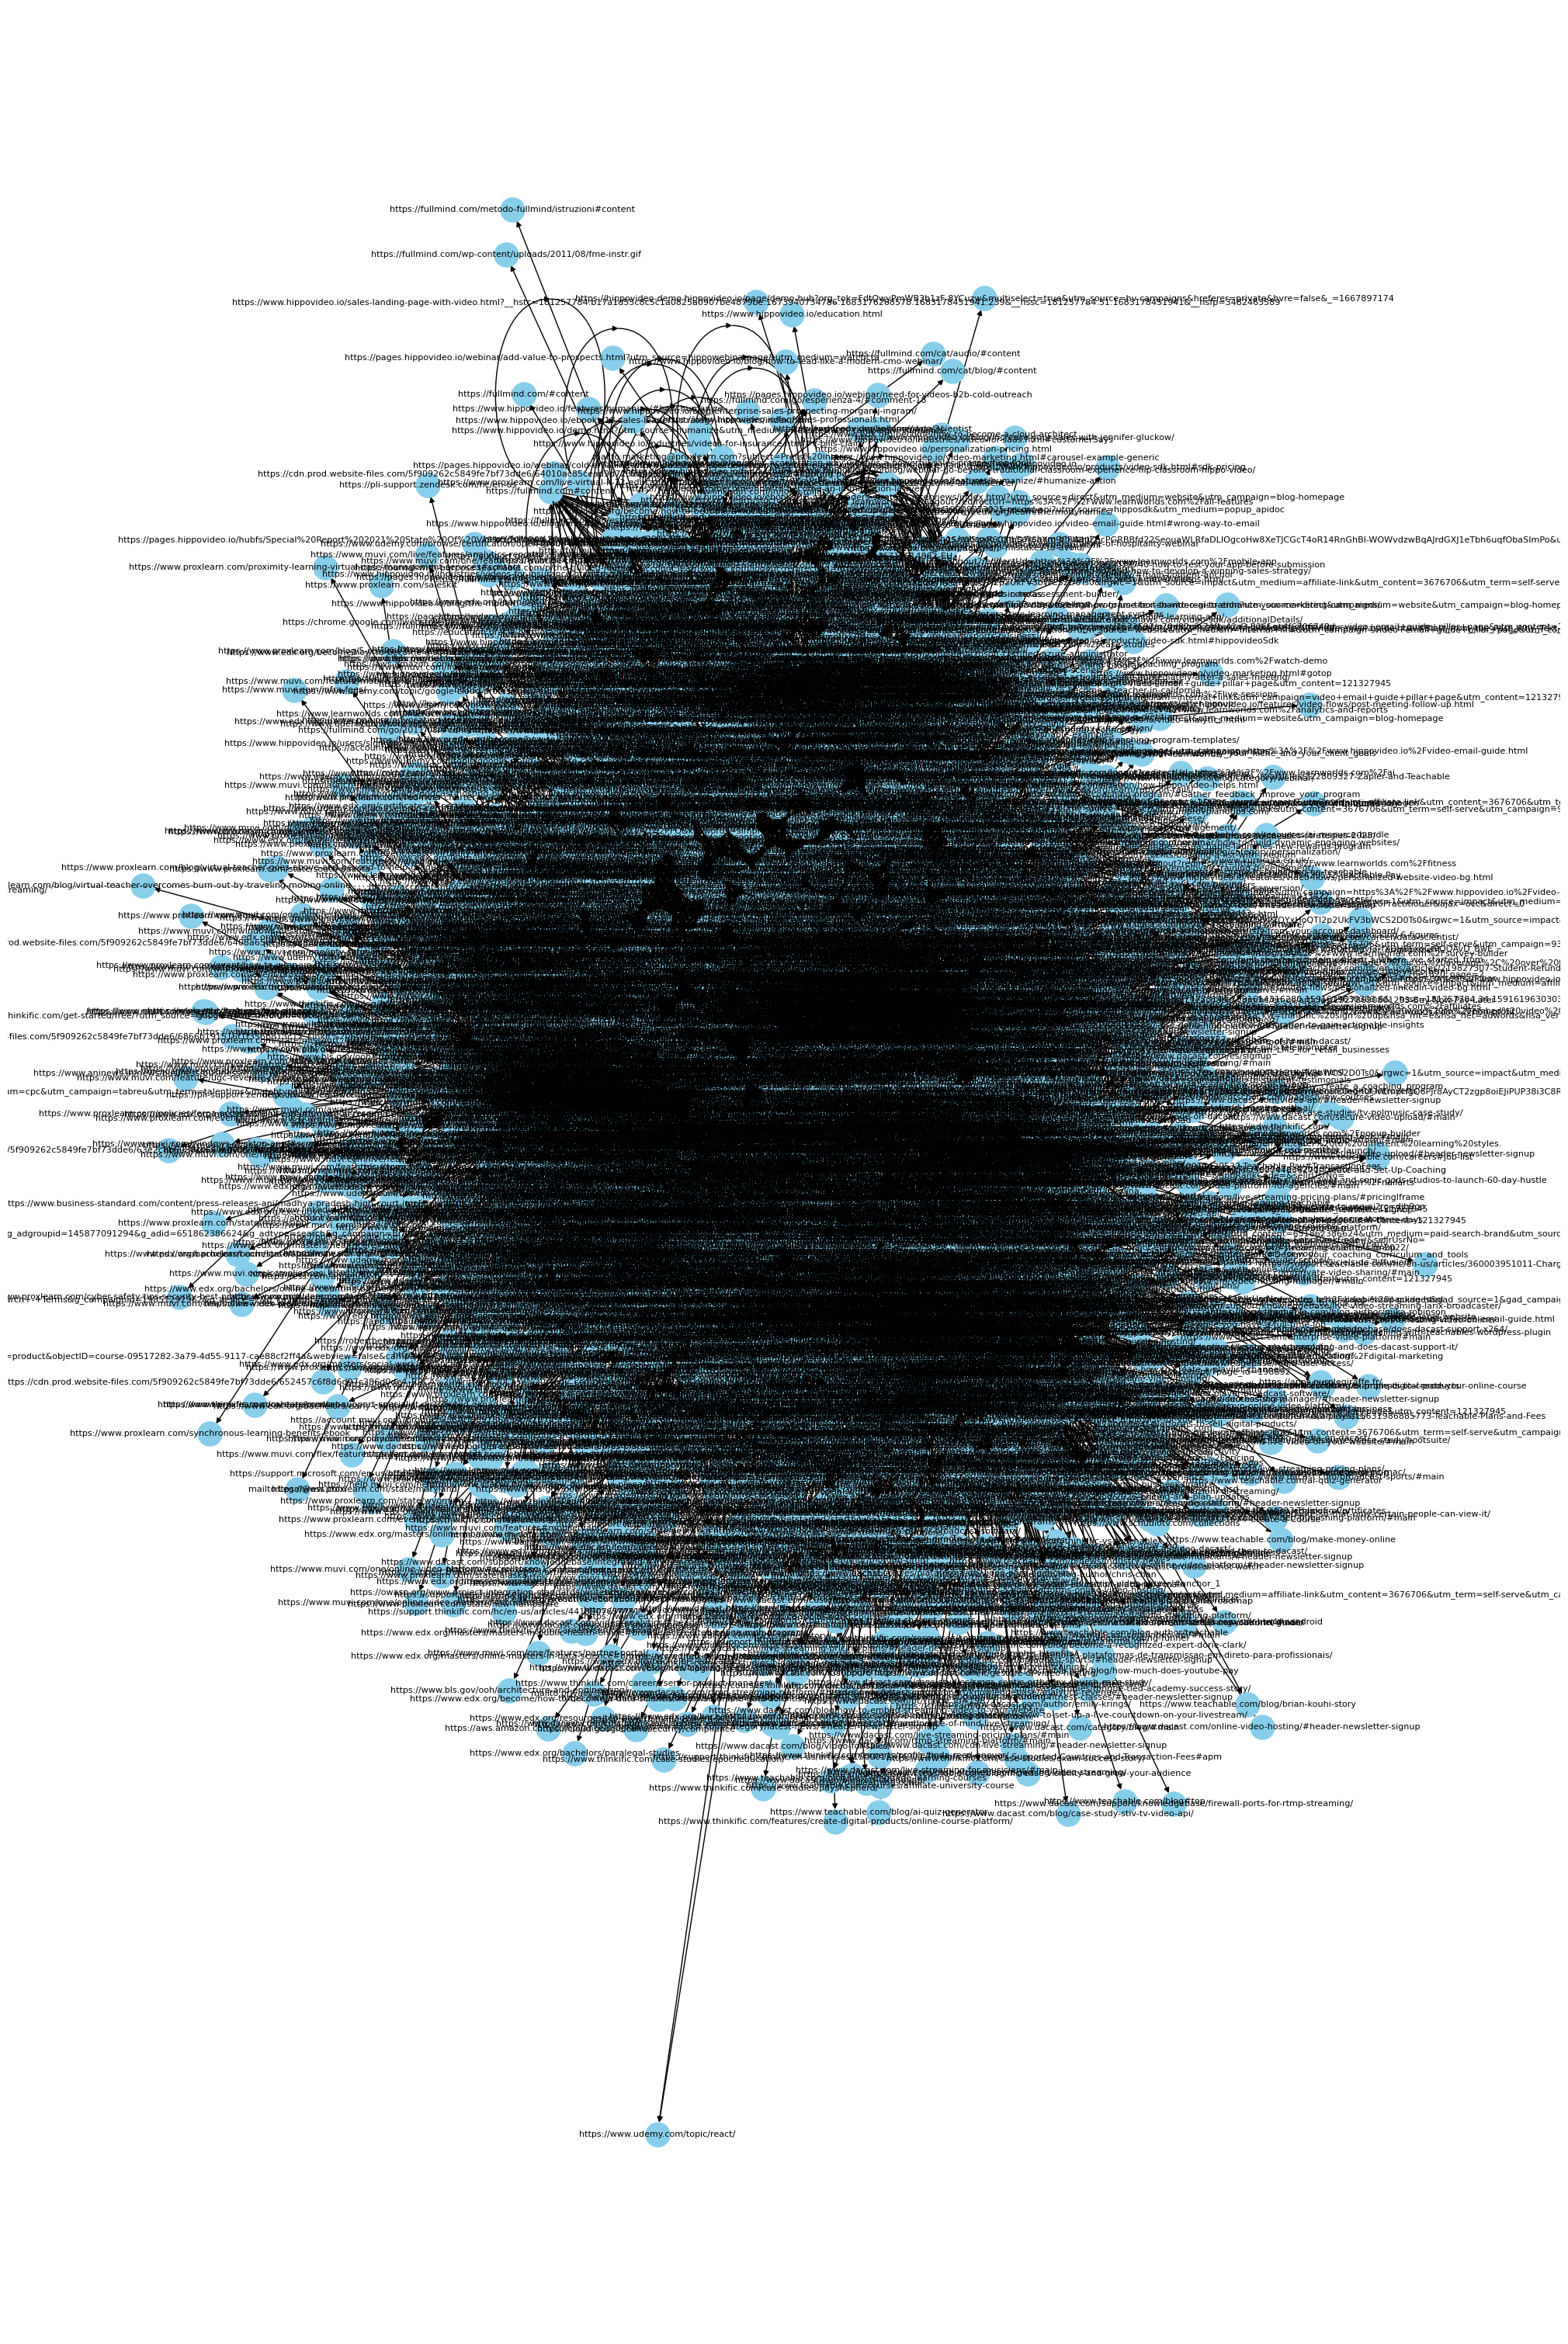

In [7]:
# -----------------------------------------------
# VISUALIZE WEB GRAPH
# -----------------------------------------------
plt.figure(figsize=(20, 30))
pos = nx.spring_layout(web_graph, k=0.5, seed=42)
nx.draw(web_graph, pos=pos, with_labels=True, node_size=500, node_color="skyblue",
        font_size=8, font_color="black", arrowsize=10)
plt.tight_layout()
plt.show()

In [8]:
# -----------------------------------------------
# PAGERANK CALCULATION
# -----------------------------------------------
pagerank_scores = nx.pagerank(web_graph, alpha=0.85, max_iter=100, tol=1e-6)

In [9]:
# -----------------------------------------------
# SEARCH FUNCTION
# -----------------------------------------------
def search_engine(query, index, scores):
    query_terms = query.lower().split()
    results = set()
    for term in query_terms:
        if term in index:
            if not results:
                results = index[term]
            else:
                results = results.intersection(index[term])

    ranked_results = [(url, scores[url]) for url in results if url in scores]
    ranked_results.sort(key=lambda x: x[1], reverse=True)
    return ranked_results

In [10]:
# -----------------------------------------------
# SAMPLE SEARCH QUERY
# -----------------------------------------------
query = "math"
print(f"\n🔎 Search Results for '{query}' using PageRank:")
results = search_engine(query, inverted_index, pagerank_scores)

for page, score in results:
    print(f"{page} ({score})")



🔎 Search Results for 'math' using PageRank:
https://www.proxlearn.com/ (0.0004631239598626085)
https://www.proxlearn.com/teach-with-us (0.0004631239598626085)
https://www.proxlearn.com/by-the-numbers (0.00044609003928573916)
https://www.proxlearn.com/courses (0.00044609003928573916)
https://www.teachable.com/industry/academics-and-languages (0.00043520492947523426)
https://www.edx.org/ (0.00037401493593135324)
https://www.edx.org/bachelors/psychology (0.00037401493593135324)
https://www.edx.org/bachelors (0.00037401493593135324)
https://www.edx.org/masters/masters-in-public-health-online (0.00037401493593135324)
https://www.edx.org/bachelors/online-accounting-bachelor-degree (0.00037401493593135324)
https://www.edx.org/learn/economics (0.00037401493593135324)
https://www.edx.org/bachelors/computer-data-sciences (0.00037401493593135324)
https://www.edx.org/learn (0.00037401493593135324)
https://www.edx.org/masters/online-masters-in-data-science (0.00037401493593135324)
https://www.edx.